In [1]:
!pip install 'ray[air]'

In [11]:
!pip install --user requests torch torchvision

In [1]:
import ray
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_dataset = torchvision.datasets.CIFAR10("data", download=True, train=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10("data", download=True, train=False, transform=transform)

train_dataset: ray.data.Dataset = ray.data.from_torch(train_dataset)
test_dataset: ray.data.Dataset = ray.data.from_torch(test_dataset)

/home/ray/anaconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified
Files already downloaded and verified


2022-12-14 10:52:10,816	INFO worker.py:1230 -- Using address localhost:9031 set in the environment variable RAY_ADDRESS
2022-12-14 10:52:12,528	INFO worker.py:1352 -- Connecting to existing Ray cluster at address: 10.0.41.53:9031...
2022-12-14 10:52:12,563	INFO worker.py:1529 -- Connected to Ray cluster. View the dashboard at https://console.anyscale.com/api/v2/sessions/ses_buwxbm99nq8dryqg6p8sbytw/services?redirect_to=dashboard 
2022-12-14 10:52:13,571	INFO packaging.py:373 -- Pushing file package 'gcs://_ray_pkg_035607a1cd206d802d656e8f005fadfc.zip' (340.87MiB) to Ray cluster...
2022-12-14 10:52:19,296	INFO packaging.py:386 -- Successfully pushed file package 'gcs://_ray_pkg_035607a1cd206d802d656e8f005fadfc.zip'.


In [2]:
train_dataset

2022-12-14 10:52:27,424	WARNING formatters.py:920 -- Missing packages: ['ipywidgets']. Run `pip install ipywidgets` for rich notebook output.


In [3]:
from typing import Dict, Tuple
import numpy as np
import torch


def convert_batch_to_numpy(batch: Tuple[torch.Tensor, int]) -> Dict[str, np.ndarray]:
    images = np.array([image.numpy() for image, _ in batch])
    labels = np.array([label for _, label in batch])
    return {"image": images, "label": labels}


train_dataset = train_dataset.map_batches(convert_batch_to_numpy)
test_dataset = test_dataset.map_batches(convert_batch_to_numpy)

Map_Batches: 100%|██████████| 200/200 [00:00<00:00, 221.77it/s]


# Train CNN

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
from ray import train
from ray.air import session, Checkpoint
from ray.train.torch import TorchCheckpoint
import torch.nn as nn
import torch.optim as optim
import torchvision


def train_loop_per_worker(config):
    model = train.torch.prepare_model(Net())

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    train_dataset_shard = session.get_dataset_shard("train")

    for epoch in range(2):
        running_loss = 0.0
        train_dataset_batches = train_dataset_shard.iter_torch_batches(
            batch_size=config["batch_size"],
        )
        for i, batch in enumerate(train_dataset_batches):
            # get the inputs and labels
            inputs, labels = batch["image"], batch["label"]

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}")
                running_loss = 0.0

        metrics = dict(running_loss=running_loss)
        checkpoint = TorchCheckpoint.from_state_dict(model.module.state_dict())
        session.report(metrics, checkpoint=checkpoint)

In [6]:
from ray.train.torch import TorchTrainer
from ray.air.config import ScalingConfig

trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config={"batch_size": 2},
    datasets={"train": train_dataset},
    scaling_config=ScalingConfig(num_workers=2),
)
result = trainer.fit()
latest_checkpoint = result.checkpoint

(RayTrainWorker pid=4977) 2022-12-14 10:52:45,758	INFO config.py:86 -- Setting up process group for: env:// [rank=0, world_size=2]
(RayTrainWorker pid=4977) 2022-12-14 10:52:45,945	INFO train_loop_utils.py:270 -- Moving model to device: cpu
(RayTrainWorker pid=4977) 2022-12-14 10:52:45,950	INFO train_loop_utils.py:330 -- Wrapping provided model in DistributedDataParallel.


(RayTrainWorker pid=4977) [1,  2000] loss: 2.232
(RayTrainWorker pid=4978) [1,  2000] loss: 2.223
(scheduler +1m8s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(scheduler +1m8s) Adding 5 node(s) of type worker-node-type-0.
(RayTrainWorker pid=4977) [1,  4000] loss: 1.892
(RayTrainWorker pid=4978) [1,  4000] loss: 1.910
(RayTrainWorker pid=4977) [1,  6000] loss: 1.656
(RayTrainWorker pid=4978) [1,  6000] loss: 1.691
(RayTrainWorker pid=4977) [1,  8000] loss: 1.579
(RayTrainWorker pid=4978) [1,  8000] loss: 1.549
(RayTrainWorker pid=4977) [1, 10000] loss: 1.471
(RayTrainWorker pid=4978) [1, 10000] loss: 1.517
(RayTrainWorker pid=4977) [1, 12000] loss: 1.461
(RayTrainWorker pid=4978) [1, 12000] loss: 1.461


Trial name,_time_this_iter_s,_timestamp,_training_iteration,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,running_loss,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
TorchTrainer_79f63_00000,39.9331,1671044046,2,2022-12-14_10-54-07,True,,e19ca8c0456c414185521de9930b0f9d,0,ip-10-0-41-53,2,10.0.41.53,4921,629.552,True,85.3643,39.9409,85.3643,1671044047,0,,2,79f63_00000,0.0409772


(scheduler +1m42s) Resized to 72 CPUs.
(RayTrainWorker pid=4977) [2,  2000] loss: 1.438
(RayTrainWorker pid=4978) [2,  2000] loss: 1.410
(RayTrainWorker pid=4977) [2,  4000] loss: 1.377
(RayTrainWorker pid=4978) [2,  4000] loss: 1.395
(scheduler +1m56s) Resized to 88 CPUs.
(RayTrainWorker pid=4977) [2,  6000] loss: 1.339
(RayTrainWorker pid=4978) [2,  6000] loss: 1.358
(RayTrainWorker pid=4977) [2,  8000] loss: 1.329
(RayTrainWorker pid=4978) [2,  8000] loss: 1.315
(RayTrainWorker pid=4977) [2, 10000] loss: 1.266
(RayTrainWorker pid=4978) [2, 10000] loss: 1.306
(RayTrainWorker pid=4977) [2, 12000] loss: 1.262
(RayTrainWorker pid=4978) [2, 12000] loss: 1.271


2022-12-14 10:54:10,025	INFO tune.py:762 -- Total run time: 93.29 seconds (93.04 seconds for the tuning loop).


(scheduler +6m53s) Removing 4 nodes of type worker-node-type-0 (idle).
(scheduler +7m0s) Removing 1 nodes of type worker-node-type-0 (idle).
(scheduler +7m6s) Resized to 24 CPUs.
(scheduler +7m11s) Resized to 8 CPUs.


# Inference

In [7]:
from ray.train.torch import TorchPredictor
from ray.train.batch_predictor import BatchPredictor

batch_predictor = BatchPredictor.from_checkpoint(
    checkpoint=latest_checkpoint,
    predictor_cls=TorchPredictor,
    model=Net(),
)

outputs: ray.data.Dataset = batch_predictor.predict(
    data=test_dataset,
    dtype=torch.float,
    feature_columns=["image"],
    keep_columns=["label"],
)

2022-12-14 11:05:39,805	WARNING compute.py:520 -- `batch_size` is set to 4096, which reduces parallelism from 200 to 3. If the performance is worse than expected, this may indicate that the batch size is too large or the input block size is too small. To reduce batch size, consider decreasing `batch_size` or use the default in `map_batches`. To increase input block size, consider decreasing `parallelism` in read.
Map Progress (1 actors 1 pending): 100%|██████████| 3/3 [00:06<00:00,  2.27s/it]


In [8]:
import numpy as np


def convert_logits_to_classes(df):
    best_class = df["predictions"].map(lambda x: x.argmax())
    df["prediction"] = best_class
    return df[["prediction", "label"]]


predictions = outputs.map_batches(convert_logits_to_classes)

predictions.show(1)

Map_Batches: 100%|██████████| 3/3 [00:00<00:00, 18.68it/s]


{'prediction': 3, 'label': 3}


In [9]:
def calculate_prediction_scores(df):
    df["correct"] = df["prediction"] == df["label"]
    return df


scores = predictions.map_batches(calculate_prediction_scores)

scores.show(1)

Map_Batches: 100%|██████████| 3/3 [00:00<00:00, 178.71it/s]


{'prediction': 3, 'label': 3, 'correct': True}


In [10]:
scores.sum(on="correct") / scores.count()

Shuffle Reduce: 100%|██████████| 1/1 [00:00<00:00, 140.03it/s]


0.5284

# Deploy endpoint

In [11]:
from ray import serve
from ray.serve import PredictorDeployment
from ray.serve.http_adapters import json_to_ndarray


serve.run(
    PredictorDeployment.bind(
        TorchPredictor,
        latest_checkpoint,
        model=Net(),
        http_adapter=json_to_ndarray,
    )
)

(ServeController pid=8091) INFO 2022-12-14 11:07:15,070 controller 8091 http_state.py:129 - Starting HTTP proxy with name 'SERVE_CONTROLLER_ACTOR:SERVE_PROXY_ACTOR-06bd1c709cbc8865d8c8531c46af9b0ace0292ab5190b9576d993e68' on node '06bd1c709cbc8865d8c8531c46af9b0ace0292ab5190b9576d993e68' listening on '127.0.0.1:8000'
(HTTPProxyActor pid=8134) INFO:     Started server process [8134]
(ServeController pid=8091) INFO 2022-12-14 11:07:16,815 controller 8091 deployment_state.py:1310 - Adding 1 replica to deployment 'PredictorDeployment'.


RayServeSyncHandle(deployment='PredictorDeployment')

In [12]:
image = test_dataset.take(1)[0]["image"]

In [13]:
import requests

payload = {"array": image.tolist(), "dtype": "float32"}
response = requests.post("http://localhost:8000/", json=payload)
response.json()

{'predictions': [0.1587877869606018,
  -2.208723306655884,
  -0.14081963896751404,
  2.143643379211426,
  -1.3325506448745728,
  1.3392208814620972,
  -0.36695003509521484,
  -0.5803686380386353,
  1.5588059425354004,
  -1.8596280813217163]}

(HTTPProxyActor pid=8134) INFO 2022-12-14 11:07:36,659 http_proxy 10.0.41.53 http_proxy.py:361 - POST / 200 29.0ms
(ServeReplica:PredictorDeployment pid=8182) INFO 2022-12-14 11:07:36,657 PredictorDeployment PredictorDeployment#jzZPvO replica.py:505 - HANDLE __call__ OK 23.9ms


In [69]:
import matplotlib.pyplot as plt
def imshow(img):
    img = img / 2 + 0.5   # unnormalize
    img = np.transpose(img, (1, 2, 0)) #(3, 32, 32)->(32, 32, 3)
    plt.imshow(img) 
    plt.show()

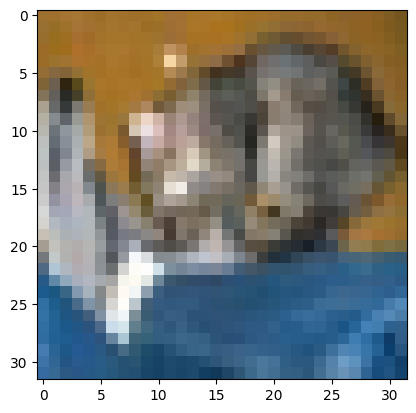

In [70]:
imshow(image)

In [53]:
serve.shutdown

<function ray.serve.api.shutdown() -> None>